# Test 2 — Regression: EDA, Data Preparation and Non-Seasonality Check

**Dataset:** Vito, S. (2008). *Air Quality* [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C59K5F  
This dataset contains hourly averaged responses from an array of gas sensors in an Air Quality Chemical Multisensor Device deployed in a polluted area.  

**Goal of this notebook**
1. **Time-based ordering:** ensure the index is a proper DateTimeIndex with a clear frequency (hourly → daily). Ensure contiguous daily index (no missing days).  
2. **Handle missing values:** summarize NaNs and **interpolate** time series (with conservative limits), fallback to forward/backward fill.  
3. **Remove/Handle outliers:** detect and cap extreme values via a robust **IQR winsorization**.   
4. **Build a non-seasonal target:** `y = diff(daily_mean(CO_GT))`.
5. **Verify non-seasonality:** STL, periodogram, Ljung–Box.

First of all, we select our environment previously created as the kernel for this notebook and run the following cell:

In [1]:
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')


# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


# package versions
import sklearn
print('python', sys.version.split()[0])
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('scikit-learn', sklearn.__version__)
print('matplotlib', plt.matplotlib.__version__)
print('seaborn', sns.__version__)


# plot defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)

python 3.10.18
pandas 2.3.2
numpy 2.2.6
scikit-learn 1.7.2
matplotlib 3.10.6
seaborn 0.13.2


In [2]:
# original url = 'https://archive.ics.uci.edu/dataset/360/air+quality/AirQualityUCI.csv' 
data_path = '../data/AirQualityUCI.csv'
# Original CSV uses semicolons (`;`), decimal commas, and marks missing values as `-200`.
df = pd.read_csv(data_path, sep=';', decimal=',', header= 0, na_values=-200)
# We avoid the last two columns which are empty
df = df.drop(columns=[c for c in df.columns if c.strip() == '' or c.startswith('Unnamed')], errors='ignore')
print('Shape:', df.shape) # 15 features 

Shape: (9357, 15)


## CLEANING AND EXPLORING DATA

In [3]:
df.head(5)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


**Attribute documentation** 
- `Date`: (DD/MM/YYYY)
- `Time`: (HH.MM.SS)
- `CO(GT)`: True hourly averaged concentration CO in mg/m^3  (reference analyzer).
- `PT08.S1(CO)`: (tin oxide) hourly averaged sensor response (nominally  CO targeted).
- `NMHC(GT)`: True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer).
- `C6H6(GT)`: True hourly averaged Benzene concentration  in microg/m^3 (reference analyzer).
- `PT08.S2(NMHC)`: (titania) hourly averaged sensor response (nominally NMHC targeted).
- `NOx(GT)`: True hourly averaged NOx concentration  in ppb (reference analyzer).
- `PT08.S3(NOx)`: (tungsten oxide) hourly averaged sensor response (nominally NOx targeted).
- `NO2(GT)`: True hourly averaged NO2 concentration in microg/m^3 (reference analyzer).
- `PT08.S4(NO2)`: (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted).
- `PT08.S5(O3)`: (indium oxide) hourly averaged sensor response (nominally O3 targeted).
- `T`: Temperature in °C.
- `RH`: Relative Humidity (%).
- `AH`: Absolute Humidity.


In [4]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       8991 non-null   float64
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             8991 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


In [5]:
# Standardize column names
df.columns = [c.strip().replace(' ', '_').replace('(', '_').replace(')', '').replace('.', '_') for c in df.columns]
df.columns

Index(['Date', 'Time', 'CO_GT', 'PT08_S1_CO', 'NMHC_GT', 'C6H6_GT',
       'PT08_S2_NMHC', 'NOx_GT', 'PT08_S3_NOx', 'NO2_GT', 'PT08_S4_NO2',
       'PT08_S5_O3', 'T', 'RH', 'AH'],
      dtype='object')

#### 1. TIME-BASED ORDERING

In [6]:
# Combine Date and Time (Date is dd/mm/yyyy; Time is HH.MM.SS)
dt= df[["Date", "Time"]].agg(' '.join, axis=1)
df.index = pd.to_datetime(dt, format='%d/%m/%Y %H.%M.%S', errors='coerce')
df= df.drop(columns=["Date", "Time"])

In [7]:
df.head()

,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


#### 2. HANDLE MISSING VALUES

- **Interpolate (time-based)**: `interpolate(method='time', limit=3)` to smoothly fill short gaps using temporal distance.
- **Safety net**: apply `ffill()` then `bfill()` to fill any remaining edge gaps without meking up new trends.
- Keep a brief “before vs after” NaN summary to document the impact.

In [8]:
# missing values ratio
df.isna().mean().sort_values(ascending=False)

NMHC_GT         0.902319
CO_GT           0.179865
NO2_GT          0.175484
NOx_GT          0.175163
PT08_S1_CO      0.039115
PT08_S2_NMHC    0.039115
C6H6_GT         0.039115
PT08_S3_NOx     0.039115
PT08_S4_NO2     0.039115
PT08_S5_O3      0.039115
T               0.039115
RH              0.039115
AH              0.039115
dtype: float64

In [9]:
daily_df = df.resample('D').mean()
full_idx = pd.date_range(daily_df.index.min(), daily_df.index.max(), freq='D')
daily_df = daily_df.reindex(full_idx)
daily_df.index

DatetimeIndex(['2004-03-10', '2004-03-11', '2004-03-12', '2004-03-13',
               '2004-03-14', '2004-03-15', '2004-03-16', '2004-03-17',
               '2004-03-18', '2004-03-19',
               ...
               '2005-03-26', '2005-03-27', '2005-03-28', '2005-03-29',
               '2005-03-30', '2005-03-31', '2005-04-01', '2005-04-02',
               '2005-04-03', '2005-04-04'],
              dtype='datetime64[ns]', length=391, freq='D')

In [10]:
# We interpolate up to 3 consecutive days of missing values. 
daily_interp = daily_df.interpolate(method='time', limit=3)
# If more than 3 days are missing, we use forward-fill and back-fill to fill any remaining NaNs at the beginning or end of the series.
daily_interp = daily_interp.ffill().bfill()
daily_interp.isna().mean().sort_values(ascending=False)


CO_GT           0.0
PT08_S1_CO      0.0
NMHC_GT         0.0
C6H6_GT         0.0
PT08_S2_NMHC    0.0
NOx_GT          0.0
PT08_S3_NOx     0.0
NO2_GT          0.0
PT08_S4_NO2     0.0
PT08_S5_O3      0.0
T               0.0
RH              0.0
AH              0.0
dtype: float64

In [11]:
# Keep a brief “before vs after” NaN summary to document the impact.
nan_before = daily_df.isna().mean().rename('NaN_before')
nan_after  = daily_interp.isna().mean().rename('NaN_after')
pd.concat([nan_before, nan_after], axis=1).sort_values('NaN_before', ascending=False).head(10)

,NaN_before,NaN_after
NMHC_GT,0.887468,0.0
CO_GT,0.092072,0.0
NOx_GT,0.086957,0.0
NO2_GT,0.086957,0.0
PT08_S1_CO,0.020460,0.0
PT08_S2_NMHC,0.020460,0.0
C6H6_GT,0.020460,0.0
PT08_S3_NOx,0.020460,0.0
PT08_S4_NO2,0.020460,0.0
PT08_S5_O3,0.020460,0.0


In [54]:
co_daily_raw = daily_interp['CO_GT'].copy() # raw target driver

#### 3. REMOVE/HANDLE OUTLIERS

We first **detect** outliers with **IQR fences** (conservative \(k=3\)) on the **daily CO level** used to form the target:
- If **no points** lie outside `[Q1 − 3·IQR, Q3 + 3·IQR]`, winsorization is **not applied** (or has no effect).
- If there are a **few** and they are likely **artefacts**, a light cap avoids undue influence on the differenced target.
- If they correspond to **genuine events** (e.g., short pollution episodes), consider **keeping** them and commenting on their impact.

Below we summarize how many potential outliers exist and whether winsorization changed anything.

In [15]:
def detect_outliers_iqr(s: pd.Series, k: float = 3.0):
    """
    Detect outliers in a time series using IQR fences.
    Returns:
      - mask: boolean Series where True = outlier
      - fences: dict with 'low' and 'high' thresholds
      - summary: DataFrame with counts and ratios
    """
    s = s.dropna()
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    mask = (s < low) | (s > high)

    summary = pd.DataFrame({
        "count_total": [len(s)],
        "count_outliers": [int(mask.sum())],
        "ratio_outliers": [mask.mean()],
        "q1": [q1],
        "q3": [q3],
        "iqr": [iqr],
        "fence_low": [low],
        "fence_high": [high],
        "k": [k],
    })
    return mask, {"low": low, "high": high}, summary

def plot_outliers_time_series(s: pd.Series, mask: pd.Series, fences: dict, title: str = None):
    """
    Plot the time series highlighting IQR outliers and showing fences as horizontal lines.
    """
    fig, ax = plt.subplots(figsize=(10,4))
    s.plot(ax=ax, label="series", lw=1)
    if mask.any():
        s[mask].plot(ax=ax, linestyle="none", marker="o", ms=5, label="outliers (IQR)", alpha=0.9)
    ax.axhline(fences["low"], ls="--", label=f"fence low ({fences['low']:.2f})")
    ax.axhline(fences["high"], ls="--", label=f"fence high ({fences['high']:.2f})")
    ax.set_title(title or "Outlier check (IQR)")
    ax.legend()
    plt.show()

def boxplot_with_fences(s: pd.Series, fences: dict, title: str = None):
    """
    Quick boxplot view with fences overlaid.
    """
    fig, ax = plt.subplots(figsize=(6,4))
    ax.boxplot(s.dropna().values, vert=True, whis=(25,75), showfliers=True)
    ax.axhline(fences["low"], ls="--", label="fence low")
    ax.axhline(fences["high"], ls="--", label="fence high")
    ax.set_title(title or "Boxplot + IQR fences")
    ax.legend()
    plt.show()

In [53]:
# Outliers detection with IQR method (k=3.0 is conservative)
mask_iqr, fences, summary = detect_outliers_iqr(co_daily_raw, k=3.0)
display(summary)  

,count_total,count_outliers,ratio_outliers,q1,q3,iqr,fence_low,fence_high,k
0,391,0,0.0,1.497826,2.67029,1.172464,-2.019565,6.187681,3.0


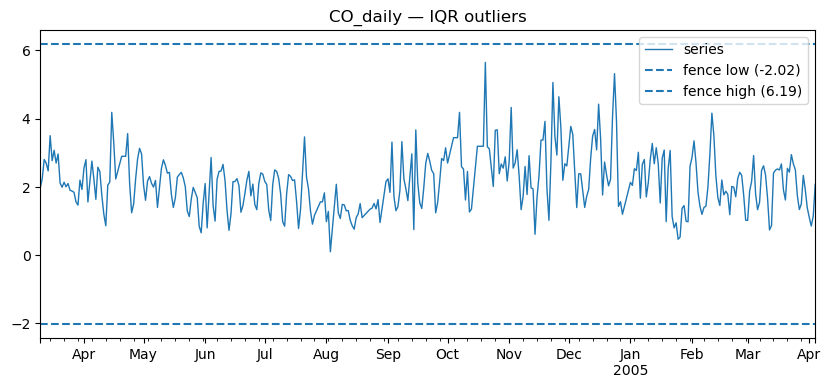

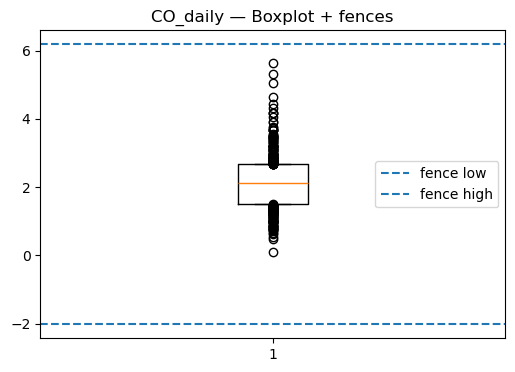

In [18]:
plot_outliers_time_series(co_daily_raw, mask_iqr, fences, title="CO_daily — IQR outliers")
boxplot_with_fences(co_daily_raw, fences, title="CO_daily — Boxplot + fences")

In our case, **no points** lie outside `[Q1 − 3·IQR, Q3 + 3·IQR]`, so winsorization is **not applied**. However, we are going to see how it is applied just in case we need to do it into another dataset.

In [12]:
def winsorize_iqr(s, iqr_mult=3.0):
    # Clip values outside [Q1 - iqr_mult*IQR, Q3 + iqr_mult*IQR]
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo = q1 - iqr_mult * iqr
    hi = q3 + iqr_mult * iqr
    return s.clip(lower=lo, upper=hi)

In [19]:
co_daily_raw = daily_interp['CO_GT'].copy() # raw target driver
co_daily_cap = winsorize_iqr(co_daily_raw, iqr_mult=3.0) # target driver with no outliers

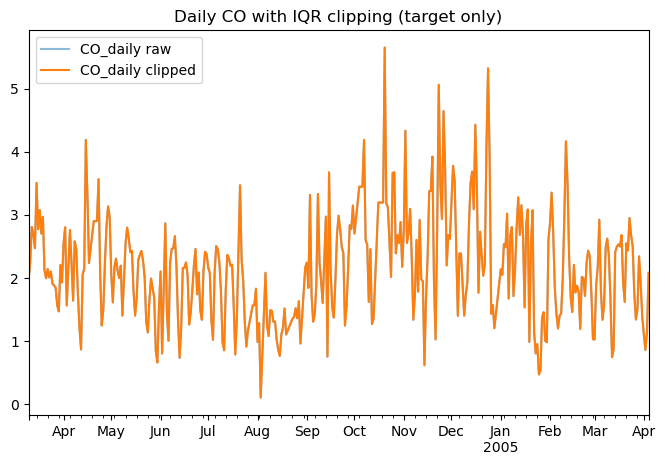

In [55]:
fig, ax = plt.subplots()
co_daily_raw.plot(ax=ax, alpha=0.5, label='CO_daily raw')
co_daily_cap.plot(ax=ax, label='CO_daily clipped')
ax.set_title('Daily CO with IQR clipping (target only)')
ax.legend(); plt.show()

Obviously both graphs are identical since **no outliers** were detected.

## NON-SEASONALITY

To use a time-series data for various purposes including model training it is required to have a seasonality free time-series data.

#### 4. BUILD A NON-SEASONAL TARGET
As target must be non-seasonal, we build a **non-seasonal target** as the **first difference** of the daily average of `CO_GT`:
  $$ y = daily_{mean}(CO\_GT).diff(1) $$
This equation represents seasonal differencing, removing any level seasonal pattern (e.g., weekly cycles) and turns the target into daily changes. 

In [25]:
y_level = co_daily_cap.dropna().rename("CO_daily")
y = y_level.diff(1).rename("y_nonseasonal")
# We check and drop NaN created by differencing
if y.isna().sum() > 0:
    y = y.dropna()

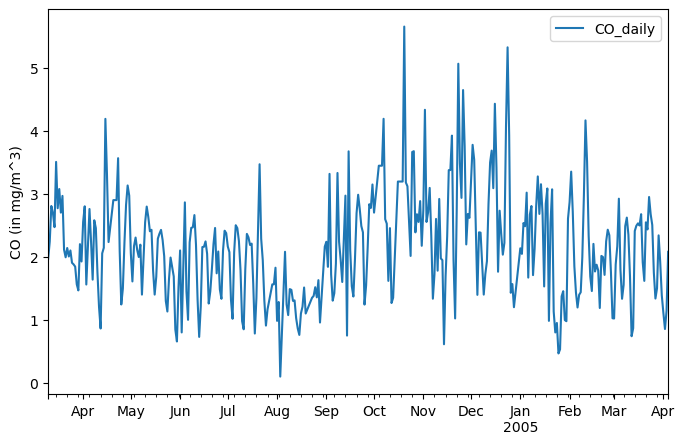

In [38]:
fig, ax = plt.subplots()
y_level.plot(ax=ax, label='CO_daily')
ax.legend()
plt.ylabel('CO (in mg/m^3)')
plt.show()

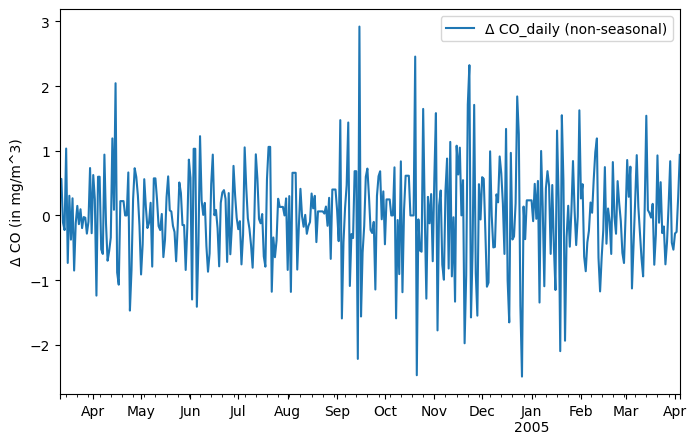

In [37]:
# We visualize the non-seasonal target
fig, ax = plt.subplots()
y.plot(ax=ax, label='Δ CO_daily (non-seasonal)')
ax.legend()
plt.ylabel('Δ CO (in mg/m^3)')
plt.show()

#### 5. VERIFY NON-SEASONALITY

**STL Decomposition (Seasonal–Trend decomposition using Loess)**

Seasonal decomposition is a statistical technique for breaking down a time series into its essential components, which often include the trend, seasonal patterns, and residual (or error) components. We decompose the the series into `Trend + Seasonal + Remainder`, using a weekly period for daily data.  
- **Trend:** The underlying long-term progression or direction in the data.
- **Seasonal:** The repeating patterns or cycles that occur at fixed intervals like daily, monthly or yearly.
- **Remainder:** The random fluctuations or noise in the data that cannot be attributed to the trend or seasonal patterns.

A common summary is the **seasonal strength**: $$\text{seasonal\_strength} = 1 - \frac{\mathrm{Var}(\text{remainder})}{\mathrm{Var}(\text{remainder} + \text{seasonal})}$$ 
  Values **near 0** indicate **no meaningful seasonality**. In our case, the differenced target shows a seasonal strength ≈ 0.

In [58]:
from statsmodels.tsa.seasonal import STL    

# We check seasonality strength 
stl = STL(y, period=7, robust=True).fit()
season_strength = max(0, 1 - (stl.resid.var() / (stl.resid.var() + stl.seasonal.var())))
print(f"Seasonal strength (0=no seasonality, 1=strong): {season_strength:.4f}")

Seasonal strength (0=no seasonality, 1=strong): 0.3109


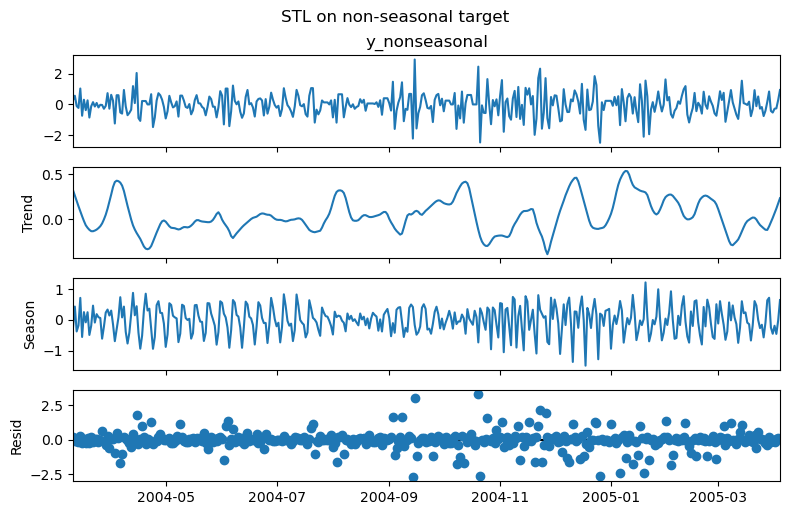

In [45]:
fig = stl.plot()
plt.suptitle('STL on non-seasonal target', y=1.02)
plt.show()


#### Periodogram

We use the periodogram to spot recurring cycles by looking at the signal in the **frequency** domain. It applies a Fourier transform and plots **power** against **frequency**; sharp peaks mark dominant periodicities. For instance, hourly temperature often shows a clear 24-hour peak. In practice, I check whether there’s a peak at the expected **seasonal frequency** (e.g., weekly ≈ 1/7 cycles/day); if no strong peak appears, that supports a **non-seasonal** target.

In [46]:
from scipy.signal import periodogram

# We create a periodogram to check for dominant frequencies
freqs, pxx = periodogram(y)

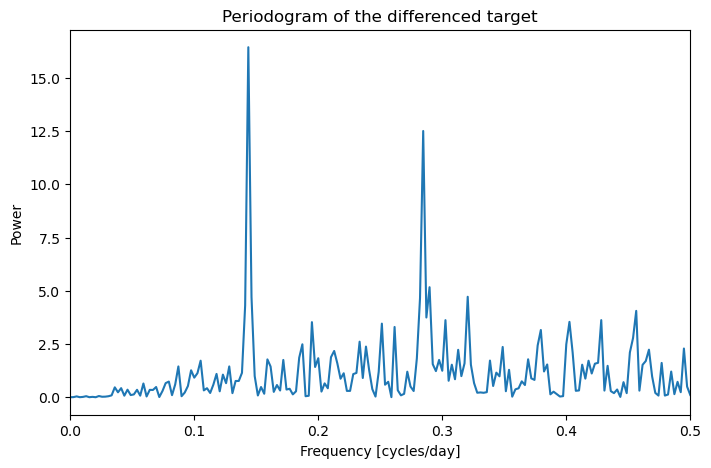

In [ ]:
fig, ax = plt.subplots()
ax.plot(freqs, pxx)
ax.set_xlim(0, 0.5)  # low frequencies (daily index -> Nyquist=0.5 cycles/day) #i don't understand this comment
ax.set_title('Periodogram of the differenced target')
ax.set_xlabel('Frequency [cycles/day]')
ax.set_ylabel('Power')
plt.show()


#### Ljung-Box 

We use the Ljung–Box test as a “portmanteau” check for **overall autocorrelation** in a series. The null hypothesis is that there is **no joint autocorrelation** up to a chosen lag \(h\). In practice, I set \(h\) to lags that make sense for the data (e.g., 7, 14, 21 days for daily series) and look at the p-values:

- **High p-values** → fail to reject \(H_0\): no evidence of joint autocorrelation up to those lags → consistent with a **non-seasonal** pattern.  
- **Low p-values** → reject \(H_0\): remaining structure (possible seasonality, residual trend, or underfit model).


In [62]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# We check for autocorrelation at seasonal lags (7, 14, 21 days)
lb = acorr_ljungbox(y, lags=[7,14,21], return_df=True)
lb

,lb_stat,lb_pvalue
7,58.501116,3.004692e-10
14,83.737529,5.700422e-12
21,111.301849,2.742924e-14


## SAVING PROCESSED DATA

In [49]:
PROCESSED_DIR = Path('../data/processed')
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

In [51]:
# We save the processed data, keeping both the level and non-seasonal target
processed = pd.concat([y_level, y], axis=1).dropna()
processed.to_parquet(PROCESSED_DIR / 'air_quality_daily.parquet')
processed.tail()

,CO_daily,y_nonseasonal
2005-03-31,1.387500,-0.529167
2005-04-01,1.108696,-0.278804
2005-04-02,0.854167,-0.254529
2005-04-03,1.141667,0.287500
2005-04-04,2.078571,0.936905
